# First make sure all the files are ready for analysis

In [1]:
import sys
sys.path.append('/home/itskov/Dropbox/workspace/lab/DeepSemantic/WormSegmentation')
%config IPCompleter.greedy=True

import matplotlib
#matplotlib.use('TkAgg')

from glob2 import glob
from Behavior.General.ExpDir import ExpDir
from Behavior.General.Experiment import Experiment
from os import listdir, path
import pandas as pd


# Debug (Temporary)
from Behavior.General import Track
sys.modules['Track'] = Track
# Debug (Temporary)

import numpy as np
import re

print('Starting..')

# Here is where the tracked files are stored.
#rootDir = '/mnt/storageNASRe/tph1/Results/24-Nov-2019'
#rootDir = '/mnt/storageNASRe/ChristianData/ChrisNewTracks/'
rootDir = '/home/itskov/Temp/behav/08-Jan-2020/'
allTrackedFiles = glob(rootDir + '/**/*tracks.npy')
allTrackedDirectories = [path.dirname(tracksFile) for tracksFile in allTrackedFiles]


# Here we store our experiments meta information
expDf = pd.DataFrame(columns=['date','time', 'cond','fullFile'])

for i, trackedDir in enumerate(allTrackedDirectories):
    fullFile = path.join(rootDir, trackedDir)
    print("%d. Going over %s" % (i, fullFile))
    
    # This object helps us manage the tracked files.
    expDir = ExpDir(str(fullFile))
    
    #if True:
    if (expDir.getExpFile() == None) or (not expDir.isValid()):
        #newExp = Experiment(expDir.getVidFile(), np.load(expDir.getTracksFile()))
        newExp = Experiment(expDir)
        newExp.takeScale()
        newExp.addCirclePotisionRad('startReg',newExp._scale / 5)
        newExp.addCirclePotisionRad('endReg',newExp._scale / 4)
        newExp.save()
        pass
        
    currentDate = re.search('\d\d-\w\w\w-\d\d\d\d',trackedDir)[0]
    currentTime = re.search('_(\d\d\.\d\d\.\d\d)',path.basename(fullFile))[1]
    cond = re.search('(.*)\.avi',path.basename(fullFile))[1]
    
    # Irregularities
    #if cond == 'STAP_Mock':
    #    cond = 'MOCK_STAP'
    #elif cond == 'LTAV_MOCK':
    #    cond = 'MOCK_LTAV'
    #elif cond == 'TEMP_EYAL_LIGHT':
    #    continue
    
    expDf.loc[i] = [currentDate, currentTime, cond, fullFile]
    #print('Date: ' + currentDate + ' Cond: ' + cond)
expDf

Starting..
0. Going over /home/itskov/Temp/behav/08-Jan-2020/TPH_1_ATR_TRAIN_70M_NO_IAA3x5.avi_13.05.52
1. Going over /home/itskov/Temp/behav/08-Jan-2020/TPH_1_NO_ATR_TRAIN_70M_NO_IAA3x5.avi_13.05.52
{}
Initializing Experiment with dir: /home/itskov/Temp/behav/08-Jan-2020/TPH_1_NO_ATR_TRAIN_70M_NO_IAA3x5.avi_13.05.52 and with 22690 tracks
{}


,date,time,cond,fullFile
0,08-Jan-2020,13.05.52,TPH_1_ATR_TRAIN_70M_NO_IAA3x5,/home/itskov/Temp/behav/08-Jan-2020/TPH_1_ATR_...
1,08-Jan-2020,13.05.52,TPH_1_NO_ATR_TRAIN_70M_NO_IAA3x5,/home/itskov/Temp/behav/08-Jan-2020/TPH_1_NO_A...



# Pair analyses

In [2]:
import sys
import pandas as pd
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, VBox,HBox

from Behavior.Visualizers.PairwiseAnalyses import PairWiseRoi
from Behavior.Visualizers.PairwiseAnalyses import PairWiseProjectionDensity, PairWiseOccupVisoulatizer, PairWiseSpeedDensity, PairWiseRevDistances
from Behavior.General.TracksFilter import filterTracksForAnalyses



# First experiment widgets
#print(pd.unique(expDf['date']))
dateWidget1 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget1 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget1 = widgets.Dropdown(options=[], description='Time')

# Second experiment widgets
dateWidget2 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget2 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget2 = widgets.Dropdown(options=[], description='Time')

out = widgets.Output()
display(out)

@out.capture()
def runAnalysis(arg):
    firstCond = condWidget1.value
    firstDate = dateWidget1.value
    firstTime = timeWidget1.value
    secondCond = condWidget2.value
    secondDate = dateWidget2.value
    secondTime = timeWidget2.value
    
    firstFile = expDf[(expDf.cond == firstCond) & 
                      (expDf.date == firstDate) & 
                      (expDf.time == firstTime)]['fullFile']
    
    secondFile = expDf[(expDf.cond == secondCond) & 
                       (expDf.date == secondDate) & 
                       (expDf.time == secondTime)]['fullFile']
    
    firstFile = path.join(firstFile.values[0],'exp.npy')
    secondFile = path.join(secondFile.values[0],'exp.npy')
    
    print(firstFile)
    print(secondFile)
    firstExp = np.load(firstFile)[0]
    secondExp = np.load(secondFile)[0]
    
    # Shortenning the experiments.
    #firstExp.trimExperiment(4500)
    #secondExp.trimExperiment(4500)
        
    print('Filtering tracks for anaylses..')
    #firstExp._tracks = filterTracksForAnalyses(firstExp._tracks)
    #secondExp._tracks = filterTracksForAnalyses(secondExp._tracks)

    PairWiseRoi(firstCond, firstExp, secondCond, secondExp)
    PairWiseProjectionDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseSpeedDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseOccupVisoulatizer(firstCond, firstExp, secondCond, secondExp)
    #PairWiseRevDistances(firstCond, firstExp, secondCond, secondExp)
    

# Run button
runButton = widgets.Button(description="Run")
runButton.on_click(runAnalysis)

def on_cond_value_change1(*change):        
    dateWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['date'])
    timeWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['time'])
    
def on_date_value_change1(*change):
    timeWidget1.options = expDf[(expDf['cond'] == condWidget1.value) & (expDf['date'] == dateWidget1.value) ]['time']
    
def on_cond_value_change2(*change):        
    dateWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['date'])
    timeWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['time'])

def on_date_value_change2(*change):
    timeWidget2.options = expDf[(expDf['cond'] == condWidget2.value) & (expDf['date'] == dateWidget2.value) ]['time']

condWidget1.observe(on_cond_value_change1, names='value')
dateWidget1.observe(on_date_value_change1, names='value')
condWidget2.observe(on_cond_value_change2, names='value')
dateWidget2.observe(on_date_value_change2, names='value')

# Display layout
HBox([VBox([condWidget1, dateWidget1, timeWidget1]), VBox([condWidget2, dateWidget2, timeWidget2]), runButton])

/home/itskov/Dropbox/workspace/homework/NeuralNetworks/venv/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/itskov/Dropbox/workspace/homework/NeuralNetworks/venv/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


Output()

# Create Pair Movie


Reinitializing.
Reinitializing.
Trimming Experiment to 6000 frames.
Trimming Experiment to 6000 frames.
Allocating space.
Filtering tracks. Before 13559, After: 6864
Allocating space.
Filtering tracks. Before 14686, After: 7043
Processed Frame 5998 / 6000[None]


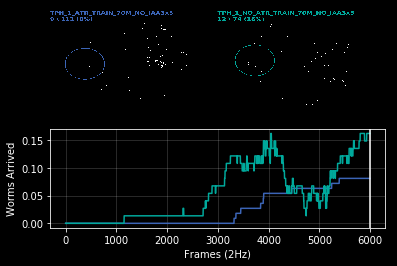

In [4]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


from Behavior.General.ExpPair import ExpPair

#expPair = ExpPair('/home/itskov/Temp/behav/12-Dec-2019/STAP_CHOICETEST.avi_13.05.52/exp.npy', 
#                  '/home/itskov/Temp/behav/12-Dec-2019/STAP_MOCK_CHOICETEST.avi_13.06.49/exp.npy')

#expPair._firstExp.trimExperiment(5501)
#expPair._secondExp.trimExperiment(5501)

#expPair.createPairVisualization(4500, dpi=250)

expPair1 = ('/home/itskov/Temp/behav/08-Jan-2020/TPH_1_ATR_TRAIN_70M_NO_IAA3x5.avi_13.05.52/exp.npy',
            '/home/itskov/Temp/behav/08-Jan-2020/TPH_1_NO_ATR_TRAIN_70M_NO_IAA3x5.avi_13.05.52/exp.npy')



expPair2 = ('/home/itskov/Temp/behav/31-Dec-2019/TPH_1_ATR_TRAIN_40M_NO_IAA3x5.avi_12.17.37/exp.npy',
            '/home/itskov/Temp/behav/31-Dec-2019/TPH_1_NO_ATR_TRAIN_40M_NO_IAA3x5.avi_12.17.01/exp.npy')


expPair3 =('/home/itskov/Temp/behav/31-Dec-2019/TPH_1_ATR_TRAIN_35M_NO_IAA3x5.avi_13.43.21/exp.npy',
           '/home/itskov/Temp/behav/31-Dec-2019/TPH_1_NO_ATR_TRAIN_35M_NO_IAA3x5.avi_13.42.39/exp.npy')




def func(expPairNames):
    expPair = ExpPair(expPairNames[0], expPairNames[1])
    expPair._firstExp.trimExperiment(6000)
    expPair._secondExp.trimExperiment(6000)

    expPair.createPairVisualization(6000, dpi=250)
    
from multiprocessing import Pool

p = Pool(1)
print(list(map(func,[expPair1])))


# Create ROI Artifact

In [ ]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


from pathlib import Path
from os import path
from Behavior.Tools.Artifacts import Artifacts
from Behavior.Visualiz

import numpy as np

rootDir = '/mnt/storageNASRe/tph1/Results/19-Nov-2019/'

for fileName in Path(rootDir).rglob('exp.npy'):
    print(fileName)
            
    # load experiment.
    exp = np.load(fileName)[0]
    
    # Create an artifact folder.
    art = Artifacts(exp)
    
    exp
    
    
        
    

# Re-Initialize Experiemnt in a new Location

In [2]:
%config IPCompleter.greedy=True

import sys
import os
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')

import numpy as np

from os import path
from Behavior.General.ExpDir import ExpDir
from glob import glob

from Behavior.Tools.Artifacts import Artifacts
from Behavior.Visualizers.RoiAnalysis import RoiAnalysis
from Behavior.Visualizers.ProjectionAnalyses import ProjectionAnalyses
from Behavior.Visualizers.OccupVisualizer import OccupVisualizer

'''expFile = '/home/itskov/Temp/behav/28-Nov-2019/TPH_1_NO_ATR_TRAIN_NO_IAA3x5.avi_17.13.10/exp.npy'
currentExp = np.load(expFile)[0]
expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))
print('Saving..')
currentExp.save()'''


DIR = '/mnt/storageNASRe/tph1/Results/'

globPath = DIR + '/**/**/exp.npy'
print(globPath)
expFiles = glob(globPath)

for i,expFile in enumerate(expFiles):
    try:
        print("%d. Going over %s" %  (i, expFile,))
        currentExp = np.load(expFile)[0]
        expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))
        
        art = Artifacts(expLocation=path.dirname(expFile))
        art.checkForArtifactsDir()
        
        roiAnalyses = RoiAnalysis(currentExp)
        projectionAnalyses = ProjectionAnalyses(currentExp)
        occupAnalyses = OccupVisualizer(currentExp)
        
        roiAnalyses.execute()
        projectionAnalyses.execute()
        occupAnalyses.execute(showPlot = False)
        
        art.addArtifact('roi', roiAnalyses._results)
        art.addArtifact('proj', projectionAnalyses._results)
        art.addArtifact('occup', occupAnalyses._results)

        
         
        print('Saving..')
        currentExp.save()
        print('Done.')
        os.system('clear')
    except Exception as ex:
        print('Error with %s: %s' % (expFile,str(ex)))

    
    

/mnt/storageNASRe/tph1/Results//**/**/exp.npy
0. Going over /mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_19.26.30/exp.npy
Reinitializing.
{'startReg': {'pos': (967.8116883116882, 1300.2792207792209), 'rad': 367.20165206411}, 'endReg': {'pos': (978.2012987012984, 204.17532467532453), 'rad': 275.4012390480825}}
Initializing Experiment with dir: /mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_19.26.30 and with 2881 tracks
{'startReg': {'pos': (967.8116883116882, 1300.2792207792209), 'rad': 367.20165206411}, 'endReg': {'pos': (978.2012987012984, 204.17532467532453), 'rad': 275.4012390480825}}
Allocating space.
Filtering tracks. Before 2881, After: 2881
Saving..
Done.
1. Going over /mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_12.14.20/exp.npy
Reinitializing.
{'startReg': {'pos': (957.4220779220777, 1289.8896103896104), 'rad': 362.715800348554}, 'endReg': {'pos': (1061.3181818181815, 204.17532467532453), 'rad': 272.03685026141